In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

from IPython.display import clear_output

In [2]:
import fulu
import utils
from binned_split import binned_train_test_split
from copy import deepcopy

In [3]:
from joblib import Parallel, delayed

In [4]:
import warnings
# warnings.filterwarnings("ignore")

# Read data

In [5]:
data = pd.read_csv('../data/ANTARES_NEW_10_in_g_r_bands.csv')

In [6]:
data.head()

,Unnamed: 0,object_id,mjd,passband,flux,flux_err,obj_type,peak_time
0,0,ZTF21abxdact,59459.475752,1,0.089995,0.005935,SN Ia,59465.47
1,1,ZTF21abxdact,59461.443414,0,0.038581,0.006491,SN Ia,59465.47
2,2,ZTF21abxdact,59461.471655,1,0.096936,0.007478,SN Ia,59465.47
3,3,ZTF21abxdact,59463.402813,1,0.095471,0.006732,SN Ia,59465.47
4,4,ZTF21abxdact,59463.436470,0,0.040974,0.006084,SN Ia,59465.47


In [7]:
object_ids = np.unique(data.object_id)
print("Number of curves is ", len(object_ids))

Number of curves is  3111


In [8]:
passband2name = {0: 'g', 1: 'r'}
passband2lam  = {0: np.log10(4741.64), 1: np.log10(6173.23)}

# Utils

In [9]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id].copy()
    return anobject

In [10]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [11]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject.loc[:, 'log_lam'] = log_lam
    return anobject

In [12]:
def is_good(anobject):
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        return 0
    
    # keep only objects with at least 7 observations in at least 3 passbands
    count = 0
    for passband in range(2):
        if len(get_passband(anobject, passband)) < 10:
            count += 1
    if count > 0:
        return 0
        
    # keep only objects without large breaks in observations
    # anobject = anobject.sort_values('mjd')
    # mjd = anobject['mjd'].values
    # if np.diff(mjd, 1).max() > 50:
    #     return 0
    
    return 1

# Visualization

In [13]:
def plot_light_curves(anobject, title="", is_plot=True):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 5.5))
    for passband in range(len(passband2name)):
        light_curve = get_passband(anobject, passband)
        if is_plot:
            plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=20)
    plt.xticks(size=18)
    plt.ylabel('Flux', size=20)
    plt.yticks(size=18)
    plt.legend(loc='best', ncol=3, fontsize=18)
    plt.title(title, size=18)

In [14]:
def plot_light_curves_with_sigma(t, flux, flux_err, passband, title=""):
    colors = ['C'+str(i) for i in range(len(np.unique(passband)))]
    plt.figure(figsize=(9, 4))
    for i, pb in enumerate(np.unique(passband)):
        plt.plot(t[passband == pb], flux[passband == pb], linewidth=2., color=colors[i])
        plt.fill_between(t[passband == pb], 
                         flux[passband == pb]+1*flux_err[passband == pb], 
                         flux[passband == pb]-1*flux_err[passband == pb], label=passband2name[pb], alpha=0.5, color=colors[i])
    plt.xlabel('Time', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

ZTF17aaazdba


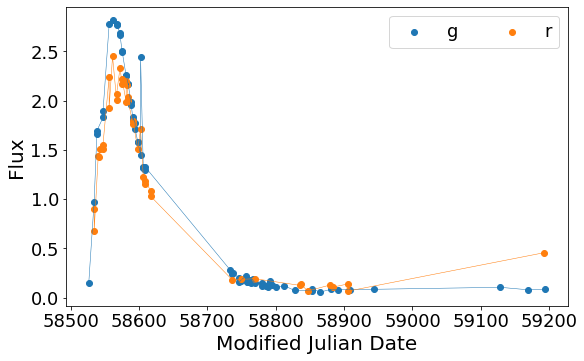

ZTF17aadlxmv


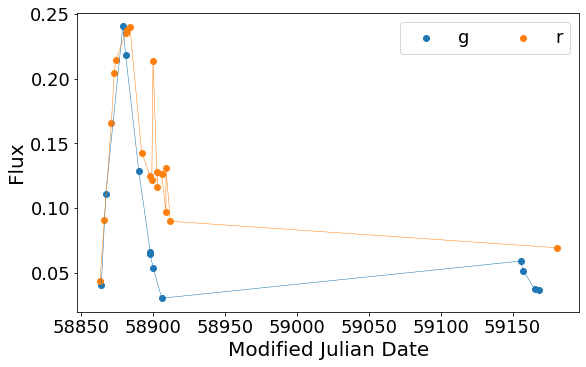

ZTF18aaaibml


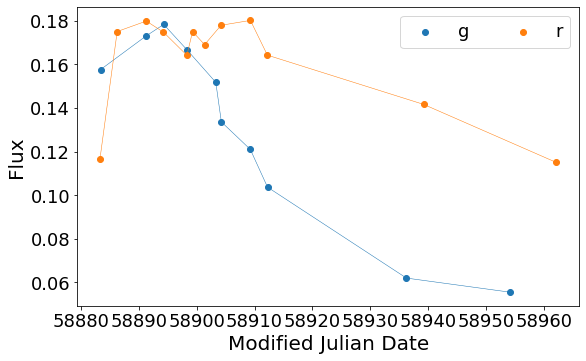

ZTF18aadzfso


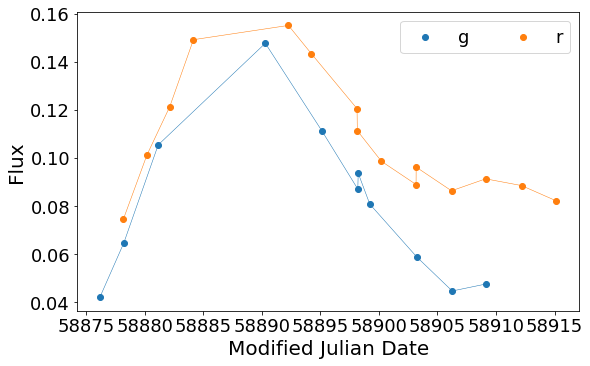

ZTF18aahatvc


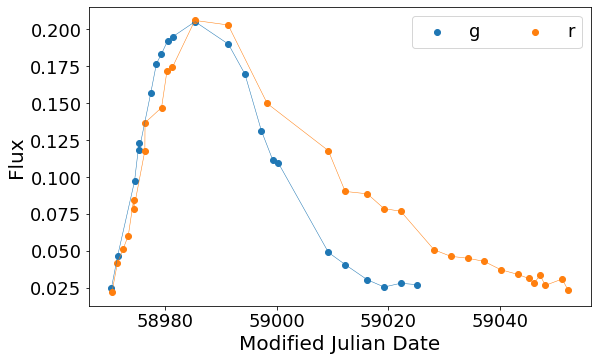

ZTF18aahfbqp


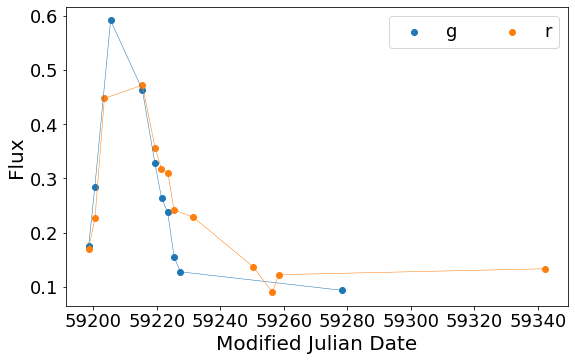

ZTF18aahtjsc


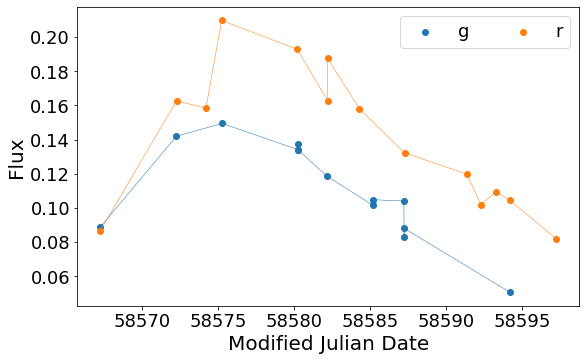

ZTF18aahvndq


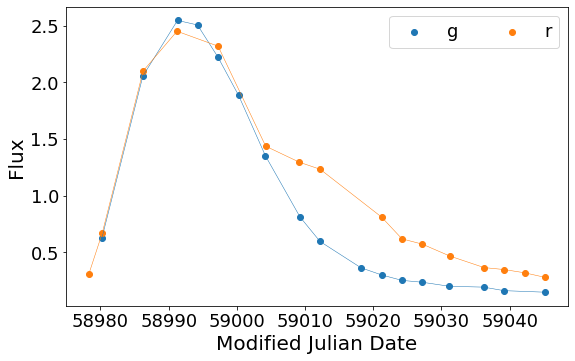

ZTF18aailmnv


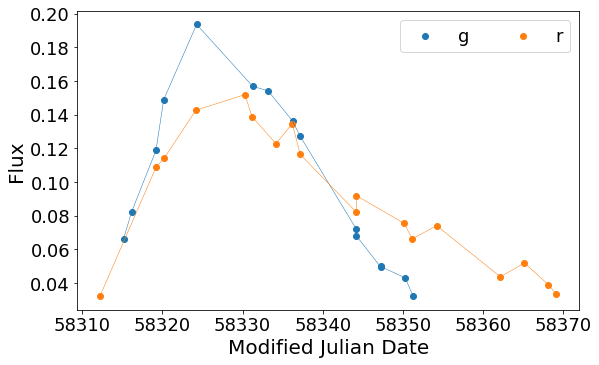

ZTF18aaisqmw


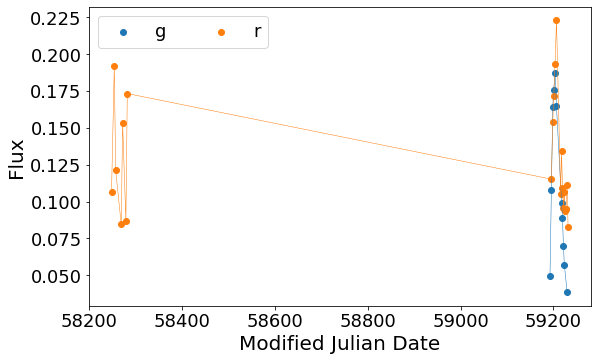

ZTF18aaiykoz


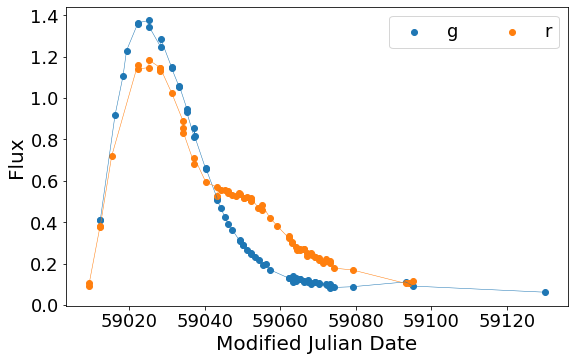

ZTF18aajivpr


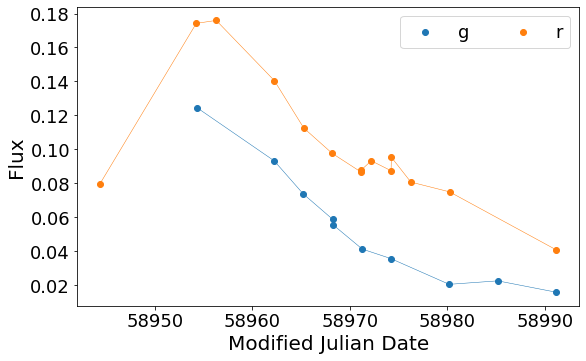

In [15]:
for i in object_ids[:20]:
    anobject = get_object(data, i)
    if not is_good(anobject):
        continue
    print(i)
    plot_light_curves(anobject)
    plt.show()

# One object test

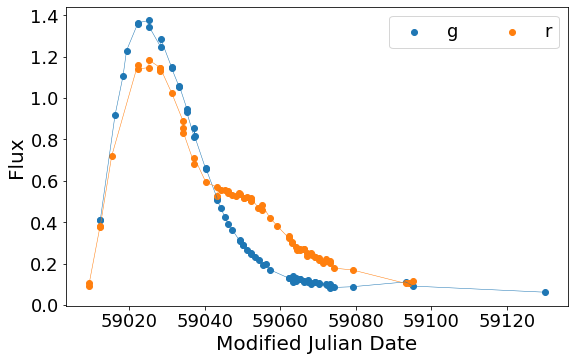

In [16]:
anobject = get_object(data, "ZTF18aaiykoz")
anobject = add_log_lam(anobject)

plot_light_curves(anobject)
# plt.savefig('light_curve_34299.pdf', format='pdf')

RMSE:  0.475416450569812
MAE:  0.3108696136975629
RSE:  1.223589509959106
RAE:  0.8527630992953453
MAPE:  35.27268588619827
NLPD:  9.8018874912339
nRMSEo:  11.51847923345716
nRMSEp:  5.007043616147757
PICP@68:  0.15384615384615385
PICP@95:  0.46153846153846156


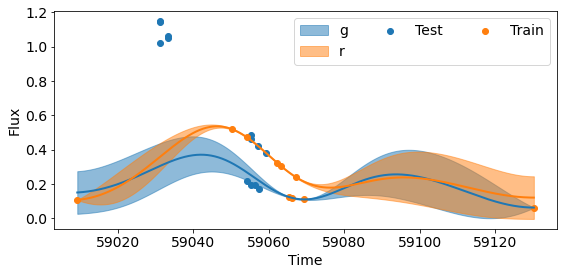

In [17]:
N = 10

# train test split
t = anobject['mjd'].values
anobject_train, anobject_test = binned_train_test_split(anobject, 
                                                        t=t, 
                                                        bin_size=5, 
                                                        test_size=2, 
                                                        shuffle=True, 
                                                        random_state=11, 
                                                        bounds_in_train=True)

t_train = anobject_train['mjd'].values
i_min = t_train.argmin()
i_max = t_train.argmax()
edges = np.array([i_min, i_max])

mask = np.arange(len(anobject_train))
mask = mask[~np.in1d(mask, edges)]

if len(mask) < N-2:
    raise Exception("Number of observation in train is smaller than %d" % (N))
elif N is not None:
    mask = np.random.RandomState(22).choice(mask, N-2, replace=False)
    mask = np.concatenate((mask, edges))



t_train = anobject_train['mjd'].values[mask]
flux_train = anobject_train['flux'].values[mask]
flux_err_train = anobject_train['flux_err'].values[mask]
passband_train = anobject_train['passband'].values[mask]

t_test = anobject_test['mjd'].values
flux_test = anobject_test['flux'].values
flux_err_test = anobject_test['flux_err'].values
passband_test = anobject_test['passband'].values

# approximation model
aug = fulu.GaussianProcessesAugmentation(passband2lam)
aug.fit(t_train, flux_train, flux_err_train, passband_train)

# augmentation
t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=1000)

# plotting
plot_light_curves_with_sigma(t_aug, flux_aug, flux_err_aug, passband_aug, title="")
plt.scatter(t_test, flux_test, label='Test')
plt.scatter(t_train, flux_train, label='Train')
plt.legend(loc='best', ncol=3, fontsize=14)

# calculate quality metrics
flux_pred_test, flux_err_pred_test = aug.predict(t_test, passband_test)
[rmse, mae, rse, rae, mape, nlpd, nrmseo, nrmsep, picp_68, picp_95] = utils.regression_quality_metrics_report(flux_test, flux_pred_test, 
                                                                                                              flux_err_test, flux_err_pred_test)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)
print("NLPD: ", nlpd)
print("nRMSEo: ", nrmseo)
print("nRMSEp: ", nrmsep)
print("PICP@68: ", picp_68)
print("PICP@95: ", picp_95)

# Test on many objects

In [18]:
def gen_report(metrics, silent=False):
    report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE', 'NLPD', 'nRMSEo', 'nRMSEp', 'PICP_68', 'PICP_95'])
    for i, met in enumerate(metrics):
        if met is not None:
            report.loc[len(report), :] = [i] + list(met)
    n_failed = report[report.MAE == -999].shape[0]
    if not silent: print("Num. of failed curves: ", n_failed)
    report = report[report.MAE != -999]
    return report

In [19]:
from sklearn.utils import resample

def bootstrap_metrics(metrics, n_iters=1000):
    means = []
    header = metrics.columns
    inds = np.arange(len(metrics))
    for i in range(n_iters):
        inds_boot = resample(inds)
        metrics_boot = metrics.iloc[inds_boot]
        means.append(metrics_boot.mean(axis=0))
    means = np.array(means)
    mu = np.round(means.mean(axis=0), 3)
    sigma = np.round(means.std(axis=0), 3)
    df = pd.DataFrame(columns=header, data=[mu, sigma], index=['mean', 'std'])
    return df

In [20]:
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, ConstantKernel as C

In [21]:
def one_object_run(i, N=None):
    
    warnings.filterwarnings("ignore")
    
    # get an object
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    # take only good curves
    if not is_good(anobject): 
        return None
    
    # train test split
    t = anobject['mjd'].values
    try:
        anobject_train, anobject_test = binned_train_test_split(anobject, 
                                                            t=t, 
                                                            bin_size=5, 
                                                            test_size=2, 
                                                            shuffle=True, 
                                                            random_state=11, 
                                                            bounds_in_train=True)
    
    except:
        print(i, len(anobject), t.max()-t.min())
        return [-999] * 10
    
    t_train = anobject_train['mjd'].values
    i_min = t_train.argmin()
    i_max = t_train.argmax()
    edges = np.array([i_min, i_max])

    mask = np.arange(len(anobject_train))
    mask = mask[~np.in1d(mask, edges)]

    if len(mask) < N-2 or N <= 2:
        return [-999] * 10
    elif N is not None:
        mask = np.random.RandomState(22).choice(mask, N-2, replace=False)
        mask = np.concatenate((mask, edges))

    t_train = anobject_train['mjd'].values[mask]
    flux_train = anobject_train['flux'].values[mask]
    flux_err_train = anobject_train['flux_err'].values[mask]
    passband_train = anobject_train['passband'].values[mask]

    t_test = anobject_test['mjd'].values
    flux_test = anobject_test['flux'].values
    flux_err_test = anobject_test['flux_err'].values
    passband_test = anobject_test['passband'].values
    
    # approximation model
    if MODEL == "GP":
        aug = fulu.GaussianProcessesAugmentation(**params)
    elif MODEL == "NN_sklearn":
        aug = fulu.MLPRegressionAugmentation(**params)
    elif MODEL == "NN_pytorch":
        aug = fulu.SingleLayerNetAugmentation(**params)
    elif MODEL == "BNN":
        aug = fulu.BayesianNetAugmentation(**params)
    elif MODEL == "NF":
        aug = fulu.NormalizingFlowAugmentation(**params)

    # fit the model
    aug.fit(t_train, flux_train, flux_err_train, passband_train)

    # calculate quality metrics
    flux_pred_test, flux_err_pred_test = aug.predict(t_test, passband_test)
    metrics = utils.regression_quality_metrics_report(flux_test, flux_pred_test, flux_err_test, flux_err_pred_test)
    
    return metrics

In [22]:
%%time

MODEL = "GP"
params = {'passband2lam': passband2lam, 
          'kernel': C(1.0) * Matern() * RBF([1, 1]) + Matern() + WhiteKernel()
         }
metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i, 5) for i in object_ids)
report_gp = gen_report(metrics)
bootstrap_metrics(report_gp)

Num. of failed curves:  10
CPU times: user 40.1 s, sys: 1.94 s, total: 42.1 s
Wall time: 46.3 s


,ID,RMSE,MAE,RSE,RAE,MAPE,NLPD,nRMSEo,nRMSEp,PICP_68,PICP_95
mean,1684.847,0.102,0.083,1.915,1.92,55.392,93.053,5.482,4.342,0.477,0.711
std,19.322,0.011,0.009,0.160,0.17,1.861,31.548,0.138,0.288,0.008,0.008


In [23]:
%%time

Ns = np.arange(6, 102, 2)


mape_mu_gp = []
mape_s_gp  = [] 

for n in Ns:
    
    
    if n%10 == 0:
        print("Status: %d observations" % (n))
    
    MODEL = "GP"
    params = {'passband2lam': passband2lam, 
              'kernel': C(1.0) * Matern() * RBF([1, 1]) + Matern() + WhiteKernel()
             }
    metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i, n) for i in object_ids)
    report = gen_report(metrics, silent=True)
    report = report[report['MAPE'] < 500]
    report = bootstrap_metrics(report)
    mape_mu_gp.append(report.loc['mean', 'MAPE'])
    mape_s_gp.append(report.loc['std', 'MAPE'])
    

Status: 10 observations
Status: 20 observations
Status: 30 observations
Status: 40 observations
Status: 50 observations
Status: 60 observations
Status: 70 observations
Status: 80 observations
Status: 90 observations
Status: 100 observations
CPU times: user 19min 12s, sys: 39.5 s, total: 19min 51s
Wall time: 26min 11s


In [24]:
%%time

mape_mu_sk = []
mape_s_sk  = [] 

for n in Ns:
    
    if n%10 == 0:
        print("Status: %d observations" % (n))
    
    MODEL = "NN_sklearn"    
    params = {'passband2lam': passband2lam, 
                              'hidden_layer_sizes': (20, 10),
                              'solver': 'lbfgs',
                              'activation': 'tanh',
                              'learning_rate_init': 0.03171745,
                              'max_iter': 9000, 
                              'batch_size': 1000, 
                              'weight_decay': 0.03109669}
    
    metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i, n) for i in object_ids)
    report = gen_report(metrics, silent=True)
    report = report[report['MAPE'] < 500]
    report = bootstrap_metrics(report)
    mape_mu_sk.append(report.loc['mean', 'MAPE'])
    mape_s_sk.append(report.loc['std', 'MAPE'])
    

Status: 10 observations
Status: 20 observations
Status: 30 observations
Status: 40 observations
Status: 50 observations
Status: 60 observations
Status: 70 observations
Status: 80 observations
Status: 90 observations
Status: 100 observations
CPU times: user 17min 2s, sys: 37.3 s, total: 17min 40s
Wall time: 18min 30s


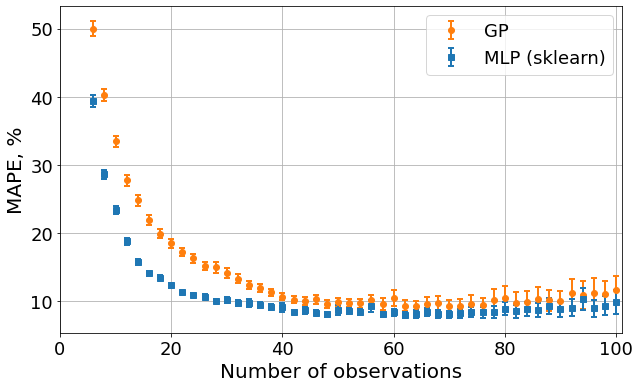

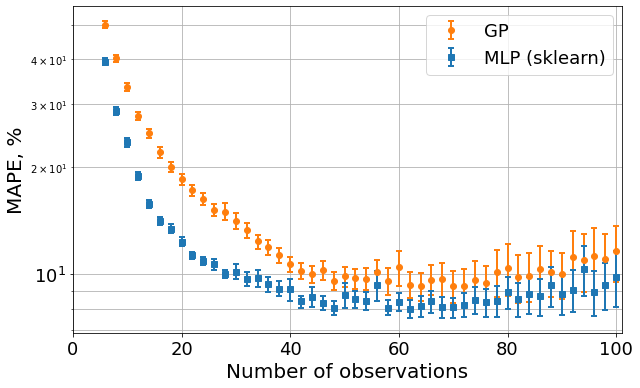

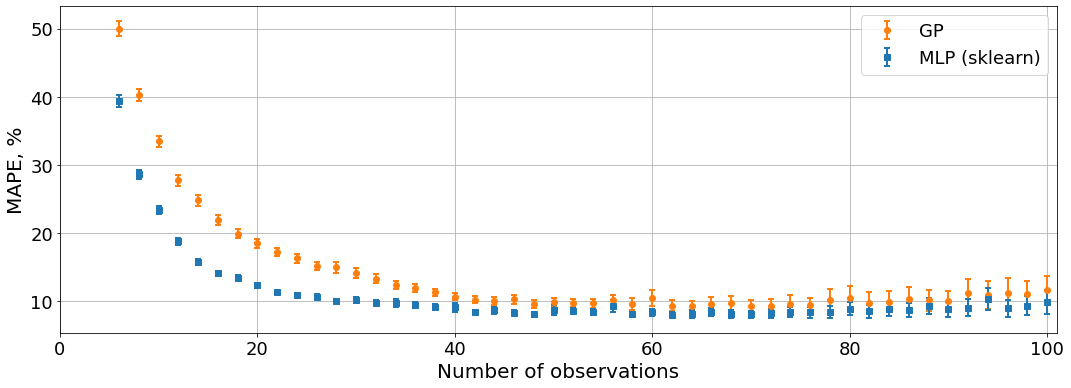

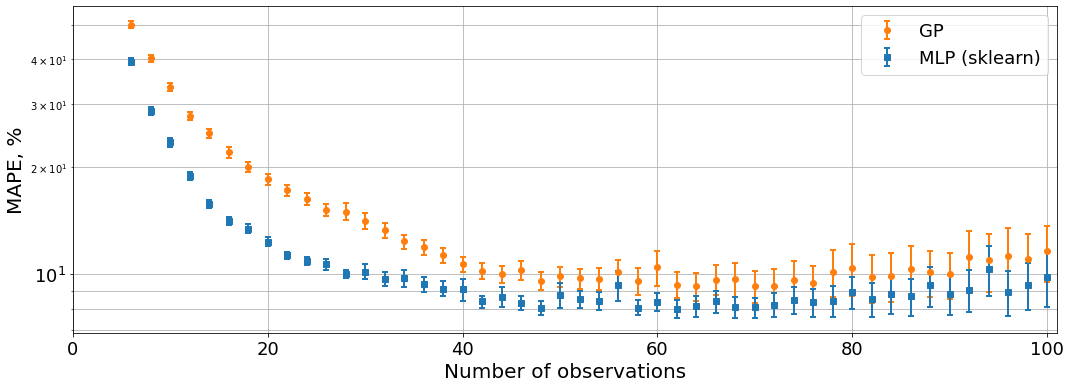

In [71]:
for mark in ['lin', 'log', '15', '15log']:

    if mark == '15' or mark == '15log':
        plt.figure(figsize=(15, 5.5))
    else:
        plt.figure(figsize=(9, 5.5))
    plt.errorbar(Ns, mape_mu_gp, yerr=mape_s_gp, fmt='o', ms=6, color='C1', elinewidth=2, capsize=3, capthick=2, ecolor='C1', label="GP")
    plt.errorbar(Ns, mape_mu_sk, yerr=mape_s_sk, fmt='s', ms=6, color='C0', elinewidth=2, capsize=3, capthick=2, ecolor='C0', label="MLP (sklearn)")
    plt.xlim(0, 101)
    plt.xlabel('Number of observations', size=20)
    plt.xticks(size=18)
    plt.ylabel('MAPE, %', size=20)
    plt.yticks(size=18)
    plt.legend(loc='best', ncol=1, fontsize=18)
    if mark == 'log' or mark == '15log':
        plt.yscale('log')
        plt.grid(which='minor', axis='y')
    plt.grid()
    plt.tight_layout()
    plt.savefig('img/mape_vs_nobs_ztf_%s.pdf' % (mark), format='pdf')
    plt.savefig('img/mape_vs_nobs_ztf_%s.png' % (mark), format='png')
    plt.show()